In [1]:
from google.colab import drive
drive.mount('/content/drive')
dirData = "./drive/MyDrive/titanik/"

Mounted at /content/drive


In [2]:
import re
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.datasets as datasets
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from os.path import exists
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
batch_size = 256
dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
#%reload_ext tensorboard 

In [ ]:
#!unzip ./drive/MyDrive/titanik/titanic.zip -d ./drive/MyDrive/titanik/

In [3]:
# load data
train = pd.read_csv(dirData+"/train.csv")
test = pd.read_csv(dirData+"/test.csv")
gender_submission = pd.read_csv(dirData+"/gender_submission.csv")
dataset = train.append(test, ignore_index=True)
# replace Gender with 0 and 1  in test & train data

dataset.Sex[dataset.Sex == 'male'] = 0 # repalce male with 0
dataset.Sex[dataset.Sex == 'female'] = 1 # repalce female with 1
# Convert Embarked into dummies using pd.get_dummies()
dummies  = pd.get_dummies(dataset.Embarked)
dataset = pd.concat([dataset,dummies],axis='columns')
dataset.drop(['Embarked'],axis='columns',inplace=True)
# replace Nan values of Cabin with U (Unknown)
dataset.Cabin = dataset.Cabin.fillna('U')
# Using Regex to find letters and categories better cabin 
dataset.Cabin = dataset.Cabin.map(lambda x:re.compile("([a-zA-Z])").search(x).group())
dataset.groupby('Cabin').size()
# replace Cabins with numbers 
cabin_dictionary = {'A':1 , 'B':2, 'C':3 , 'D':4 , 'E':5 , 'F':6 , 'G':7 , 'T':8 , 'U':9}

dataset = dataset.replace({'Cabin':cabin_dictionary})
# combaine number of siblings and  spouses  to get  FamilySize 
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# replace missing Fare value of test data with median of Fares 
dataset.Fare = dataset.Fare.fillna(dataset.Fare.median())
# drop unused columns of test and train data 
dataset = dataset.drop(['Name','SibSp', 'Parch', 'Ticket'], axis = 1)
# split train  and test set 
train_main = dataset[dataset['Survived'].notna()] # train set Survived != null
test_main  = dataset[dataset['Survived'].isnull()] # train set Survived == null
# replace Missing values of age row with mean age of each Ticket class (Pclass) of train data
def clean_training_age(columns) :
    Age = columns[0]
    Pclass = columns[1]
    
    if pd.isnull(Age):
        if Pclass ==1 :
            return 37
        elif  Pclass == 2 :
            return 29
        else : 
            return 24
    else : 
        return Age
# replace Missing values of age  with mean age of each Ticket class (Pclass) of test data
def clean_test_age(columns) :
    Age = columns[0]
    Pclass = columns[1]
    
    if pd.isnull(Age):
        if Pclass ==1 :
            return 44
        elif  Pclass == 2 :
            return 27
        else : 
            return 23
    else : 
        return Age
# fill age missing values with mean age of each Pclass according to the  boxplot
train_main.Age = train_main[['Age','Pclass']].apply(clean_training_age,axis=1) 
test_main.Age = test_main[['Age','Pclass']].apply(clean_test_age,axis=1) 
# drop Survived of  test data 
test_main.drop('Survived',axis =1,inplace=True)
train_main.head()
x_train = train_main.drop('Survived',axis=1) # independent
y_train = train_main.Survived # dependent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/

In [15]:
X_train, X_validate, y_train, y_validate = train_test_split( x_train, y_train, test_size=0.3, random_state=41)

In [17]:
test = torch.tensor(test_main.values.astype(np.float32)).to(device)
#DataLoader(data_utils.TensorDataset(X_train, y_train)  , batch_size=batch_size,shuffle=False)

In [18]:
y_train = torch.tensor(y_train.values.astype(np.float32)).to(device)
X_train = torch.tensor(X_train.values.astype(np.float32)).to(device)
y_validate = torch.tensor(y_validate.values.astype(np.float32)).to(device)
X_validate = torch.tensor(X_validate.values.astype(np.float32)).to(device) 
y_validate = y_validate.unsqueeze(1)

In [19]:
batch_size = 50
train_loader = DataLoader(data_utils.TensorDataset(X_train, y_train)  , batch_size=batch_size,shuffle=True)
validate_loader = DataLoader(data_utils.TensorDataset(X_validate, y_validate), batch_size=batch_size,shuffle=True)

In [12]:
model_default = torch.nn.Sequential(
    torch.nn.Linear(10, 500),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(500, 1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(1000, 500),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),

    torch.nn.Linear(500, 1),
).to(device)

In [20]:

def loss_plot(fig, ax, train_loss, test_loss, loss_name):
    train_line = ax.plot(train_loss, color = 'black')
    test_line = ax.plot(test_loss, color = 'red')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel(loss_name)
    ax.legend(('Тренировочная выборка', 'Тестовая выборка'))
    fig.canvas.draw()

In [ ]:
from scipy.signal import savgol_filter
from sklearn.utils import shuffle

0
100
200
300
400


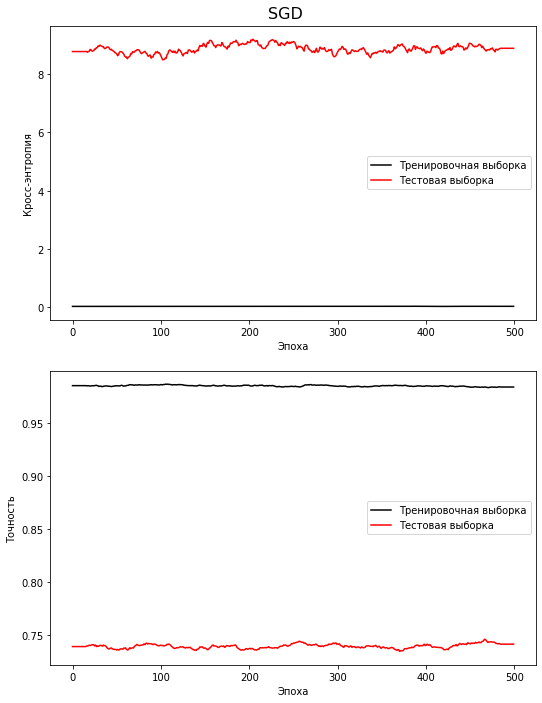

In [ ]:
lr = 0.000001 #скорость обучения

#log_dir = dirData+ "logdir/" + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
#log_dir=log_dir+"-lr="+str(lr)+";"
#log_dir=log_dir+"-bs="+str(batch_size)+";"
#writer = SummaryWriter(log_dir)

%matplotlib inline
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(2,1)
fig.tight_layout(pad=3.0)

ax1, ax2 = ax
train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = 500



optimizer = torch.optim.Adam(model_default.parameters(), lr = lr)
 
cross_entropy = torch.nn.BCEWithLogitsLoss ()
for i in range(epochs):
    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch=0
    for x, y in train_loader:
        x, y = shuffle(x, y)
        #x = torch.tensor(x)
        #print(type(x))
        #print(x)
        y_hat = model_default(x)
        #print(y_hat)

        y = y.unsqueeze(1)
        #print(y_hat, y)
        loss = cross_entropy(y_hat, y)
        train_loss_epoch += loss.item()
        #print(y_hat,y)
        train_acc_epoch += torch.mean((y == (y_hat>0.0).float()).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_epoch / len(train_loader))
    train_acc.append(train_acc_epoch / len(train_loader))
    
    with torch.no_grad():
            y_hat = model_default(X_validate)
            #test_loss_epoch = cross_entropy(y_hat, y_validate)
            test_loss.append(cross_entropy(y_hat, y_validate))
            test_acc.append(
                torch.mean((y_validate == (y_hat>0.0).float()).float()))
            #test_acc.append(torch.mean((y_test == torch.argmax(y_hat, 1)).float()))
    #writer.add_scalars('Loss', {'train':train_loss_epoch,'test':test_loss_epoch,}, i)
    if i%100 ==0 :
        print(i)
            #test_loss.append(cross_entropy(y_hat, y_test))
            #test_acc.append(
                #torch.mean((y_test == torch.argmax(y_hat, 1)).float()))

train_loss = savgol_filter(train_loss, window_length=31, polyorder=0)
test_loss = savgol_filter(test_loss, window_length=31, polyorder=0)
train_acc = savgol_filter(train_acc, window_length=31, polyorder=0)
test_acc = savgol_filter(test_acc, window_length=31, polyorder=0)

fig.suptitle('SGD', fontsize=16)
loss_plot(fig,ax1,train_loss, test_loss, "Кросс-энтропия")
loss_plot(fig,ax2,train_acc,test_acc  , "Точность")
#writer.close()

In [ ]:
#!rm -rf ./logdir/ 

In [10]:
!ls ./drive/MyDrive/titanik/model/2021-05-24-17-59-14

2021-05-24-17-59-14


In [8]:
PATH = dirData+"model/"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [13]:

#model_default.load_state_dict(torch.load("./drive/MyDrive/titanik/model/2021-05-24-17-59-14"))


<All keys matched successfully>

In [ ]:
PATH

'./drive/MyDrive/titanik/model/2021-05-24-17-59-14'

In [ ]:
torch.save(model_default.state_dict(), PATH)

In [ ]:
!ls ./drive/MyDrive/titanik/

gender_submission.csv  logdir  model  test.csv	titanic.zip  train.csv


In [21]:
y_hat = model_default(test)

In [ ]:
y_hat > 0 

In [ ]:
device

device(type='cuda')

In [ ]:
#gender_submission[pd.Series ((y_hat > 0 ).reshape(-1).cpu().numpy())] 

In [76]:
gender_submission["Survived"] = gender_submission["Survived"].astype(int)

In [80]:
 
gender_submission.to_csv("ans.csv" ,index=False)